# Language Model Fine-tuning

This notebook demonstrates fine-tuning a language model for a generation task.

Task: Given a name, generate its reverse (e.g., emma → amme)

In [1]:
data = open('names.txt').read().splitlines()
print(f"Total names: {len(data)}")
data[0:10]

Total names: 32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Load the model and tokenizer

In [2]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens
tokenizer.add_special_tokens({
    "pad_token": "<|pad|>",
    "bos_token": "<|startoftext|>",
})

# Resize embeddings to account for new tokens
# This call resizes the embedding matrix, initializes new rows randomly , and keeps old embeddings unchanged
model.resize_token_embeddings(len(tokenizer))

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model parameters: 134,516,160


## Test the model before fine-tuning

In [3]:
test_names = ['emma', 'noah', 'olivia']

print("Before fine-tuning:")
print("="*50)

for name in test_names:
    prompt = f"<|startoftext|>Reverse the name: {name}. Answer:"
    inputs = tokenizer(prompt, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=20,
            temperature=1.0,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"{response}")

Before fine-tuning:
Reverse the name: emma. Answer: The word emma is a contraction for Emma.

It turns out that emma was my
Reverse the name: noah. Answer: no.
     4) Pizza - pizza.
    • Q: What is the name of the
Reverse the name: olivia. Answer: 9/46

3/425-D Heal the world by the number


## Create dataset

Format: `<|startoftext|>Reverse the name: emma. Answer: amme<|endoftext|>`

In [4]:
from torch.utils.data import Dataset, DataLoader
import random

class NameReversalDataset(Dataset):
    def __init__(self, names, tokenizer, max_length=64):
        self.names = names
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        reversed_name = name[::-1]
        full_text = f"{self.tokenizer.bos_token}Reverse the name: {name}. Answer: {reversed_name}{self.tokenizer.eos_token}"
        prompt = f"{self.tokenizer.bos_token}Reverse the name: {name}. Answer:"

        return {
            'full_text': full_text,
            'prompt': prompt,
            'name': name,
            'reversed': reversed_name
        }

    def collate_fn(self, batch):
        full_texts = [item['full_text'] for item in batch]
        prompts = [item['prompt'] for item in batch]

        tokenized = self.tokenizer(
            full_texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        labels = tokenized['input_ids'].clone()

        # Mask the prompt tokens in the labels (set to -100 so they're ignored in loss)
        for i, prompt in enumerate(prompts):
            prompt_tokens = self.tokenizer(prompt, add_special_tokens=False)['input_ids']
            prompt_len = len(prompt_tokens)
            labels[i, :prompt_len] = -100  # Ignore prompt tokens in loss calculation

        return {
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': labels
        }

# Split data
random.seed(123)
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

train_data = data[:n1]
dev_data = data[n1:n2]
test_data = data[n2:]

print(f"Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)}")

# Create datasets
train_dataset = NameReversalDataset(train_data, tokenizer)
dev_dataset = NameReversalDataset(dev_data, tokenizer)
test_dataset = NameReversalDataset(test_data, tokenizer)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=dev_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

Train: 25626, Dev: 3203, Test: 3204


## Examine a batch

In [5]:
# Look at a sample batch
sample_batch = next(iter(train_loader))
print("Sample batch shape:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['labels'].shape}")

# Decode first example
print("\nFirst example:")
input_text = tokenizer.decode(sample_batch['input_ids'][0], skip_special_tokens=True)
print(f"Input: {input_text}")

# Show which tokens are masked in labels
label_tokens = sample_batch['labels'][0]
valid_label_indices = (label_tokens != -100).nonzero(as_tuple=True)[0]
if len(valid_label_indices) > 0:
    valid_labels = label_tokens[valid_label_indices]
    label_text = tokenizer.decode(valid_labels, skip_special_tokens=True)
    print(f"Target (answer only): {label_text}")

Sample batch shape:
  input_ids: torch.Size([16, 17])
  attention_mask: torch.Size([16, 17])
  labels: torch.Size([16, 17])

First example:
Input: Reverse the name: osyris. Answer: siryso
Target (answer only):  siryso


## Training loop

In [ ]:
import torch.optim as optim
from tqdm import tqdm

learning_rate = 5e-5
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        # gradient clipping is one of those small details that makes training stable
        # This rescales gradients if their global norm exceeds max_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Update progress bar
        if batch_idx % 10 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(dev_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Average validation loss: {avg_val_loss:.4f}")

Epoch 1/3:  45%|████▍     | 715/1602 [02:51<03:04,  4.81it/s, loss=1.3548]

## Generate and evaluate

In [ ]:
def generate_reversal(model, tokenizer, name, device, max_new_tokens=20):
    prompt = f"{tokenizer.bos_token}Reverse the name: {name}. Answer:"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode and extract the answer
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the answer part
    if "Answer:" in full_response:
        answer = full_response.split("Answer:")[1].strip()
        # Remove any extra text after the first word (the reversed name)
        answer = answer.split()[0] if answer else ""
        return answer
    return ""

# Test on some examples
print("After fine-tuning:")
print("="*50)
test_names = ['emma', 'noah', 'olivia', 'liam', 'sophia', 'mason', 'isabella', 'william', 'mia', 'james']

correct = 0
for name in test_names:
    generated = generate_reversal(model, tokenizer, name, device)
    expected = name[::-1]
    is_correct = generated == expected
    correct += is_correct

    symbol = "✓" if is_correct else "✗"
    print(f"{name:10} → {generated:10} (expected: {expected:10}) {symbol}")

print(f"\nAccuracy: {correct}/{len(test_names)} = {correct/len(test_names)*100:.1f}%")

After fine-tuning:
emma       → amme       (expected: amme      ) ✓
noah       → haon       (expected: haon      ) ✓
olivia     → aivilo     (expected: aivilo    ) ✓
liam       → mail       (expected: mail      ) ✓
sophia     → aihpos     (expected: aihpos    ) ✓
mason      → nosam      (expected: nosam     ) ✓
isabella   → allebasi   (expected: allebasi  ) ✓
william    → luottiw    (expected: mailliw   ) ✗
mia        → aim        (expected: aim       ) ✓
james      → semaj      (expected: semaj     ) ✓

Accuracy: 9/10 = 90.0%


## Evaluate on test set

In [ ]:
def evaluate_accuracy(model, tokenizer, test_names, device, sample_size=None):
    """Evaluate exact match accuracy on test set."""
    if sample_size:
        test_names = random.sample(test_names, min(sample_size, len(test_names)))

    correct = 0
    errors = []

    for name in tqdm(test_names, desc="Evaluating"):
        generated = generate_reversal(model, tokenizer, name, device)
        expected = name[::-1]

        if generated == expected:
            correct += 1
        else:
            errors.append((name, expected, generated))

    exact_match_acc = correct / len(test_names)

    return {
        'exact_match_accuracy': exact_match_acc,
        'errors': errors
    }

# Evaluate on a sample of test data
results = evaluate_accuracy(model, tokenizer, test_data, device, sample_size=200)

print(f"Exact Match Accuracy: {results['exact_match_accuracy']*100:.2f}%")
print(f"\nNumber of errors: {len(results['errors'])}/200")

# Show some errors
if results['errors']:
    print("\nSome examples of errors:")
    print("Name\t\tExpected\tGenerated")
    print("="*45)
    for name, expected, generated in results['errors'][:10]:
        print(f"{name:12}\t{expected:12}\t{generated}")

Evaluating: 100%|██████████| 200/200 [00:13<00:00, 14.31it/s]

Exact Match Accuracy: 81.00%

Number of errors: 38/200

Some examples of errors:
Name		Expected	Generated
fizza       	azzif       	asirof
dayra       	aryad       	ayrad
scout       	tuocs       	kcarts
meilah      	haliem      	halime
ayaanreddy  	yddernaaya  	ydirdaanya
lejla       	aljel       	aljeel
monserratt  	ttarresnom  	ttarrsecm
jahnae      	eanhaj      	eahnaj
tsion       	noist       	noits
harmony     	ynomrah     	ytinohsm


## Analysis by name length

Evaluating: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


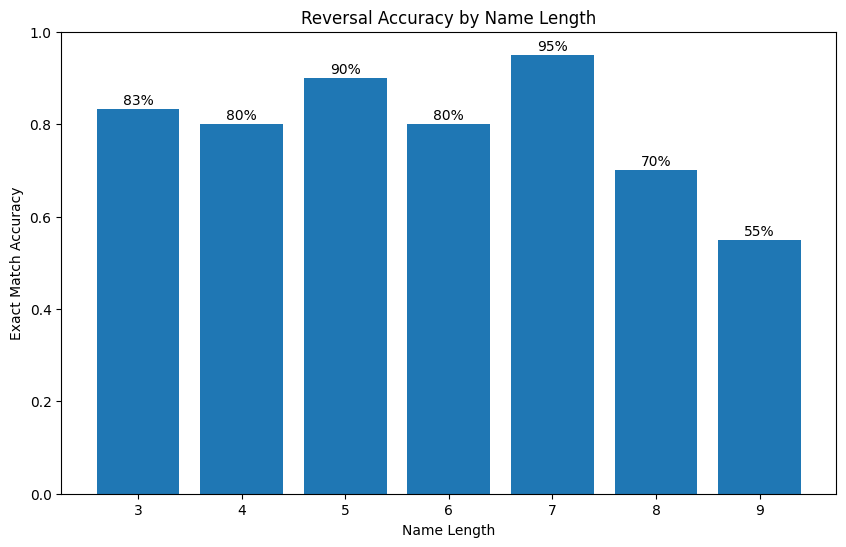

Accuracy by name length:
  Length 3: 83.3% (6 names in test set)
  Length 4: 80.0% (41 names in test set)
  Length 5: 90.0% (112 names in test set)
  Length 6: 80.0% (147 names in test set)
  Length 7: 95.0% (124 names in test set)
  Length 8: 70.0% (46 names in test set)
  Length 9: 55.0% (20 names in test set)


In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Group test names by length
names_by_length = defaultdict(list)
for name in test_data[:500]:  # Use first 500 for speed
    names_by_length[len(name)].append(name)

# Evaluate accuracy by length
length_accuracies = {}
lengths = sorted(names_by_length.keys())

for length in lengths:
    if len(names_by_length[length]) >= 5:  # Only evaluate if we have enough samples
        names_subset = names_by_length[length][:20]  # Limit to 20 per length for speed
        results = evaluate_accuracy(model, tokenizer, names_subset, device)
        length_accuracies[length] = results['exact_match_accuracy']

# Plot
if length_accuracies:
    plt.figure(figsize=(10, 6))
    lengths = list(length_accuracies.keys())
    accuracies = list(length_accuracies.values())

    plt.bar(lengths, accuracies)
    plt.xlabel('Name Length')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Reversal Accuracy by Name Length')
    plt.ylim(0, 1.0)

    # Add percentage labels on bars
    for i, (l, acc) in enumerate(zip(lengths, accuracies)):
        plt.text(l, acc + 0.01, f'{acc*100:.0f}%', ha='center')

    plt.show()

    # Print summary
    print("Accuracy by name length:")
    for length, acc in sorted(length_accuracies.items()):
        count = len(names_by_length[length])
        print(f"  Length {length}: {acc*100:.1f}% ({count} names in test set)")

## Test with different prompt formats

In [ ]:
# Try different prompt variations to see if the model generalizes
test_prompts = [
    ("Reverse the name: {name}. Answer:", "Train"),
    ("Reverse: {name} =>", "Variation 1"),
    ("What is {name} backwards?", "Variation 2"),
    ("{name} reversed is:", "Variation 3"),
]

test_name = "sophia"
expected = test_name[::-1]

print(f"Testing different prompts for '{test_name}' (expected: {expected})")
print("="*60)

for prompt_template, prompt_type in test_prompts:
    prompt = tokenizer.bos_token + prompt_template.format(name=test_name)

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=20,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract answer (everything after the prompt)
    answer = response[len(prompt_template.format(name=test_name)):].strip().split()[0] if len(response) > len(prompt_template.format(name=test_name)) else ""

    is_correct = answer == expected
    symbol = "✓" if is_correct else "✗"

    print(f"{prompt_type:10}:")
    print(f"  Prompt: {prompt_template.format(name=test_name)[:40]}...")
    print(f"  Output: {answer:10} {symbol}")


Testing different prompts for 'sophia' (expected: aihpos)
Train     :
  Prompt: Reverse the name: sophia. Answer:...
  Output: aihpos     ✓
Variation 1:
  Prompt: Reverse: sophia =>...
  Output: aihpos     ✓
Variation 2:
  Prompt: What is sophia backwards?...
  Output:            ✗
Variation 3:
  Prompt: sophia reversed is:...
  Output: aihsopi    ✗
